# Neural Network activations research

This research tries to address 3 topics for neural networks:
- test how a single layer neural network can learn a multivariate gaussian distribution
- test the impact of the type of the activation on the layer has on the result
- implement a new custom activation based on RELU and test its impact - TODO

For this research our own library was created named matmih.

### Import required libraries

In [1]:
# We require at least tensorflow 2.3 and tensorflow-probability 0.11
import sys
import os
import warnings
%reload_ext autoreload
%autoreload

def mount_gdrive():
    # Import the library and kaggle config files from gdrive
    GDRIVE_PATH='/content/gdrive/RESEARCH'
    if 'google.colab' in sys.modules:
        from google.colab import drive
        import shutil
        drive.mount('/content/gdrive')
        sys.path.append(GDRIVE_PATH)
        os.makedirs('/root/.kaggle/', exist_ok=True)
        shutil.copyfile(GDRIVE_PATH + 'kaggle.json', '/root/.kaggle/kaggle.json')
        !chmod 600 '/root/.kaggle/kaggle.json'

def install_modules():
    !pip install --quiet kaggle
    !pip install --quiet pandas
    !pip install --quiet scikit-learn
    !pip install --quiet scikit-image
    !pip install --quiet scipy
    !pip install --quiet statsmodels
    !pip install --upgrade --quiet tensorflow
    !pip install --upgrade --quiet tensorflow-probability
    !pip install --quiet randomcolor
    !pip install --quiet matplotlib
    !pip install --quiet Pillow
    !pip install --quiet arviz
    !pip install --quiet seaborn
    !pip install --quiet prettytable

mount_gdrive()
#install_modules()

import matmih as mm
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.python.platform.build_info.build_info)

Num GPUs Available:  1
{'cuda_version': '64_101', 'cudnn_version': '64_7', 'cuda_compute_capabilities': ['sm_35', 'sm_37', 'sm_52', 'sm_60', 'sm_61', 'compute_70'], 'cpu_compiler': 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.26.28801/bin/HostX64/x64/cl.exe', 'is_rocm_build': False, 'is_cuda_build': True, 'msvcp_dll_names': 'msvcp140.dll,msvcp140_1.dll', 'nvcuda_dll_name': 'nvcuda.dll', 'cudart_dll_name': 'cudart64_101.dll', 'cudnn_dll_name': 'cudnn64_7.dll'}


### Multivariate normal dataset creation
Created a dataset using by sampling from multivariate normal distribution for the features and using a categorical distribution for the classes. Each class will have its own mean and covariance.

Since the data distribution is know the best estimator is Bayes so we can compute the baseline best accuracy class as 
$ argmax(P(C_i) * P_{MVNdistro}(features)) $

In [2]:
class Distr_DataSet:
    def __init__(self, class_probs, feature_distributions):
        assert(len(class_probs) == len(feature_distributions))

        self._no_classes = len(class_probs)
        self._class_choice = tfp.distributions.Categorical(probs=class_probs)
        self._distr = feature_distributions
        self._feature_shape = feature_distributions[0].event_shape
    
    def sample(self, N):
        s = np.zeros((N, *self._feature_shape))
        choice = self._class_choice.sample(N)
        for i in range(N):
            s[i] = self._distr[choice[i]].sample(1).numpy().squeeze()
        return s, choice.numpy()
    
    def bayes_classifier(self, features):
        classes = np.zeros(len(features), dtype=np.int32)
        class_scores = np.array([self._class_choice.prob(i) for i in range(self._no_classes)])
        for j, feature in enumerate(features):
            scores = np.array([self._distr[i].prob(feature) for i in range(self._no_classes)])
            classes[j] = np.argmax(class_scores * scores)
        
        return classes
            

class BinaryMVNormal_Data(Distr_DataSet):
    def __init__(self, class_prob, no_features):
        unifA = tfp.distributions.Uniform(low=[-5] * no_features, high=[5] * no_features)
        unifB = tfp.distributions.Uniform(low=[5] * no_features, high=[15] * no_features)
        
        locA = unifA.sample()
        locB = unifB.sample()

        trilA=tf.linalg.LinearOperatorLowerTriangular(unifA.sample(sample_shape=(no_features,))).to_dense()
        trilB=tf.linalg.LinearOperatorLowerTriangular(unifB.sample(sample_shape=(no_features,))).to_dense()

        self._classAfeatures=tfp.distributions.MultivariateNormalTriL(loc=locA, scale_tril=trilA, name='classA')
        self._classBfeatures=tfp.distributions.MultivariateNormalTriL(loc=locB, scale_tril=trilB, name='classB')

        
        super(BinaryMVNormal_Data, self).__init__([class_prob, 1 - class_prob], [self._classAfeatures, self._classBfeatures])
        
# sample a binamial classification dataset
data = BinaryMVNormal_Data(0.5, 3)
features, classes = data.sample(100)
bayes_classes = data.bayes_classifier(features)
print("BAYES ACCURACY {}".format(mm.Model.accuracy(classes, bayes_classes)))

BAYES ACCURACY 1.0


### Configurable NN model
Using matmih library we create a configurable neural network model using Keras.

All model parameters including the hidden layer size and activation as well as the train epochs, optimier and so on can be configured by passing a hyperparameter dictinary.

In [3]:
class NNModel(mm.TensorModel):
    BATCH_SIZE = 32

    def __init__(self, **hyper_params):
        self._hyper_params = hyper_params.copy()
        no_classes = hyper_params.get('noClasses', 2)
        if no_classes == 2:
            no_classes = 1

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hyper_params.get('sizeL1', 10),
                                  input_shape=(hyper_params.get('noFeatures', 4),),
                                 name='Hidden_1'),
            tf.keras.layers.BatchNormalization(name='Hidden_1_BN'),
            tf.keras.layers.Activation(hyper_params.get('actL1', 'relu'),
                                      name='Hidden_1_Activation'),
            tf.keras.layers.Dense(no_classes, name='Output_Logits'),
            tf.keras.layers.Activation('softmax', name='softmax')
               if no_classes > 1 else
            tf.keras.layers.Activation('sigmoid', name='sigmoid')
            ], name=hyper_params.get('model_name', 'NN'))
        super(NNModel, self).__init__(model, checkpoint=False)

        self._train_epochs = hyper_params.get('trainEpochs', 20)
        self._optimizer = hyper_params.get('optimizer', tf.keras.optimizers.RMSprop())

        # compile the model and initialize the weights
        self._model.compile(
             optimizer=self._optimizer,
             loss='sparse_categorical_crossentropy' if no_classes > 1 else 'binary_crossentropy',
             metrics=['accuracy'])

    # Convert the features/target np data to a tensorflow dataset
    @staticmethod
    def np_to_tf(features, target=None, batch_size=BATCH_SIZE):
        if target is None:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32)) )
        else:
            ds = tf.data.Dataset.from_tensor_slices( (tf.cast(features, tf.float32),
                                                      tf.cast(target, tf.int32)) )

        return ds if batch_size is None else ds.batch(batch_size)

    def train(self, data_model, logTensorBoard=False):
        callbacks = []
        if logTensorBoard:
            callbacks += [tf.keras.callbacks.TensorBoard(mm.TensorBoard.get_log_dir(), histogram_freq=1)]

        train_ds = NNModel.np_to_tf(data_model.train_features, data_model.train_target)
        validation_ds = NNModel.np_to_tf(data_model.validation_features, data_model.validation_target)

        history = self._model.fit(train_ds, validation_data=validation_ds,
                                  epochs=self._train_epochs, callbacks=callbacks,
                                  verbose=self._hyper_params.get('verbose', 1))

        return mm.ModelHistory(self._hyper_params, history.history)

    def predict(self, features):
        features_ds = tf.cast(features, tf.float32)
        return self._model.predict_classes(features_ds), self._model.predict(features_ds)

# Print the summary of the model used for multiclass classification
NNModel(noFeatures=4, noClasses=3, denseSize=5)._model.summary()

Model: "NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_1 (Dense)             (None, 10)                50        
_________________________________________________________________
Hidden_1_BN (BatchNormalizat (None, 10)                40        
_________________________________________________________________
Hidden_1_Activation (Activat (None, 10)                0         
_________________________________________________________________
Output_Logits (Dense)        (None, 3)                 33        
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 123
Trainable params: 103
Non-trainable params: 20
_________________________________________________________________


### GUReLU - Gaussian Uniform ReLU
Inspired from Relu6 activation paper [http://www.cs.utoronto.ca/~kriz/conv-cifar10-aug2010.pdf] we propose a new activation where the constant 6 is replaced by a random variable.

Noise added is from a HalfNormal distribution meaning we always increase the activation by some amount.

In [8]:
from tensorflow.keras import backend as K
from tensorflow.python.keras.utils.generic_utils import get_custom_objects

threshold = tfp.distributions.Uniform(low=0.0, high=10.0)
noise = tfp.distributions.HalfNormal(scale=1)

@tf.custom_gradient
def gurelu_activation(x):
    max_value = threshold.sample((1,1))
    
    @tf.function
    def grad(dy):
        zero_grad = tf.zeros(shape=(1, dy.shape[1]), dtype=dy.dtype)
        dy_grelu = tf.where(tf.math.less(x, 0), zero_grad, dy)
        dy_grelu = tf.where(tf.math.greater(x, max_value), zero_grad, dy)
        return dy_grelu

    min_value = tf.constant(0, shape=(1,1), dtype=x.dtype)
    x_relu = tf.clip_by_value(x, min_value, max_value)
    x_relu = tf.math.add(x_relu, noise.sample((1, x.shape[1])))
    return x_relu, grad

get_custom_objects().update({'gurelu': tf.keras.layers.Activation(gurelu_activation)})

### Models training and evaluation
First we create a binary classification distribution using only 3 featured sampled from the above multivariate normal dataset class.

We train and run the models on **independent** samples from the same distribution so that we can correctly do statistical tests on the results

In [9]:
ACTIVATIONS = ['gurelu', 'relu', 'tanh', 'softplus']
HISTORY = mm.ModelHistorySet()
PARAMS = {'noFeatures' : features.shape[1], 'noClasses' : 2, 'trainEpochs' : 100, 'verbose' : 0}
DISTRIBUTION = BinaryMVNormal_Data(0.5, 3)
NMV_SAMPLES = [1000, 1000, 1000, 1000, 1000, 1000, 1000]
#NMV_SAMPLES = [100]

for i, no_samples in enumerate(NMV_SAMPLES):
    features, classes = DISTRIBUTION.sample(no_samples)
    ds = mm.DataModel(features, classes).split([0.8, 0.2])
    print("{}SAMPLES={} BAYES ACCURACY={}{}".format(
        '='*20, no_samples, mm.Model.accuracy(classes, DISTRIBUTION.bayes_classifier(features)), '='*20))
    
    for activation in ACTIVATIONS:
        for layer_size in [features.shape[1], 2*features.shape[1], 4*features.shape[1]]:
            model = NNModel(model_name='NN_sample{}'.format(i), **PARAMS,
                            sizeL1=layer_size, actL1=activation)

            history = model.train(ds)
            HISTORY.add_history(history)
            print('>>>MODEL activation={} dense_layer={:2d} >>> BEST ACCURACY TRAIN={:.3f} VALIDATION={:.3f}'.format(
                activation, layer_size,
                max(history.history('accuracy', mm.DataType.TRAIN)),
                max(history.history('accuracy', mm.DataType.VALIDATION))))
            model.destroy()
            del model

====================SAMPLES=1000 BAYES ACCURACY=0.978====================
>>>MODEL activation=gurelu dense_layer= 3 >>> BEST ACCURACY TRAIN=0.892 VALIDATION=0.955
>>>MODEL activation=gurelu dense_layer= 6 >>> BEST ACCURACY TRAIN=0.910 VALIDATION=0.960
>>>MODEL activation=gurelu dense_layer=12 >>> BEST ACCURACY TRAIN=0.908 VALIDATION=0.960
>>>MODEL activation=relu dense_layer= 3 >>> BEST ACCURACY TRAIN=0.955 VALIDATION=0.970
>>>MODEL activation=relu dense_layer= 6 >>> BEST ACCURACY TRAIN=0.947 VALIDATION=0.970
>>>MODEL activation=relu dense_layer=12 >>> BEST ACCURACY TRAIN=0.955 VALIDATION=0.975
>>>MODEL activation=tanh dense_layer= 3 >>> BEST ACCURACY TRAIN=0.933 VALIDATION=0.965
>>>MODEL activation=tanh dense_layer= 6 >>> BEST ACCURACY TRAIN=0.938 VALIDATION=0.965
>>>MODEL activation=tanh dense_layer=12 >>> BEST ACCURACY TRAIN=0.936 VALIDATION=0.970
>>>MODEL activation=softplus dense_layer= 3 >>> BEST ACCURACY TRAIN=0.936 VALIDATION=0.965
>>>MODEL activation=softplus dense_layer= 6 >>

### Plot the results of the training
Use a continous line for the training set metric and dashed line for validation for each trained sample.

We split the results per activation function.

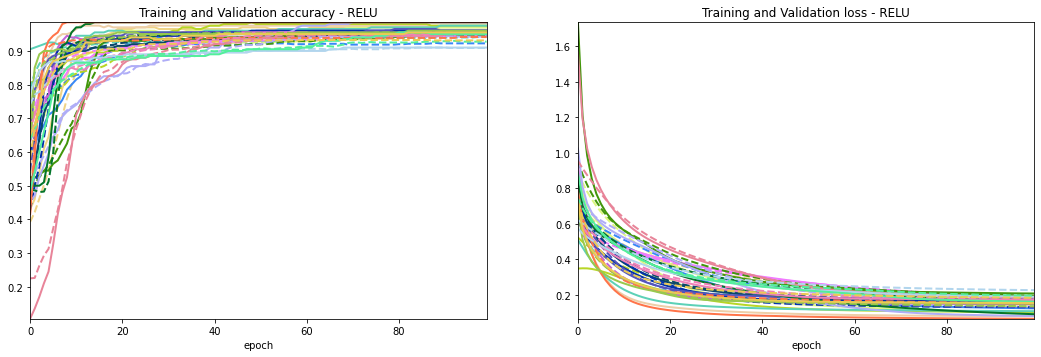

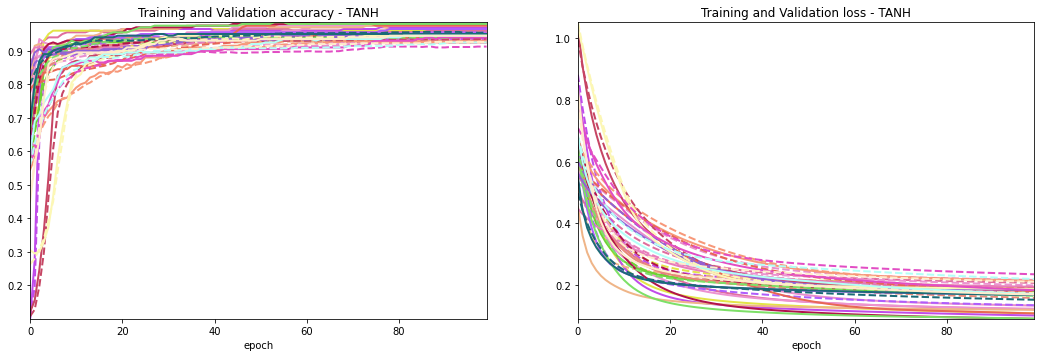

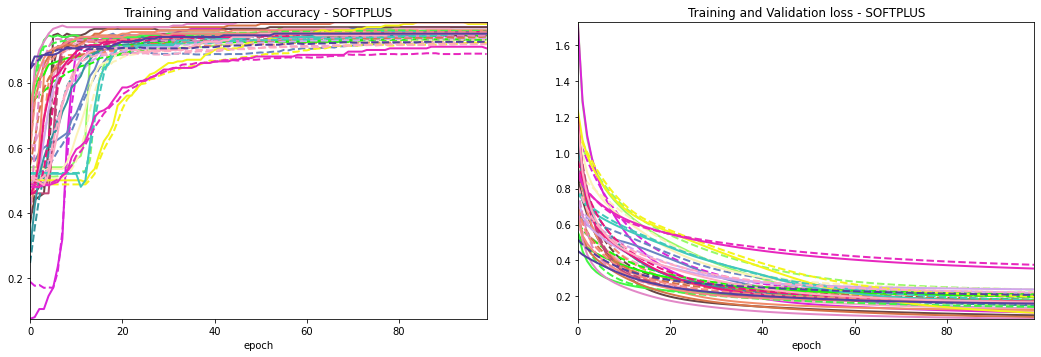

In [11]:
EVALUATION = mm.ModelEvaluation(HISTORY).set_filter_params(['actL1', 'sizeL1'])

EVALUATION.plot_history('RELU', ['accuracy', 'loss'], actL1='relu')
EVALUATION.plot_history('TANH', ['accuracy', 'loss'], actL1='tanh')
EVALUATION.plot_history('SOFTPLUS', ['accuracy', 'loss'], actL1='softplus')

## Models evaluation
We use statistical tests to see if there is any statistical difference between **best accuracy** of the models.

To do this we this the data is represented for each model (e.g. model with activation RELU and layer size 12) as the best accuracy given by each of the train-validation accuracy result for each independent sample from the distribution.

### Models accuracy distribution
Plot the distribution of the best accuracy for each models.

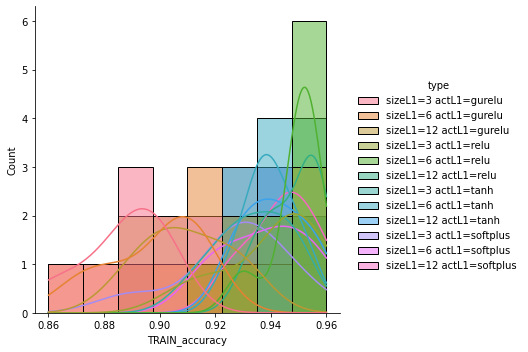

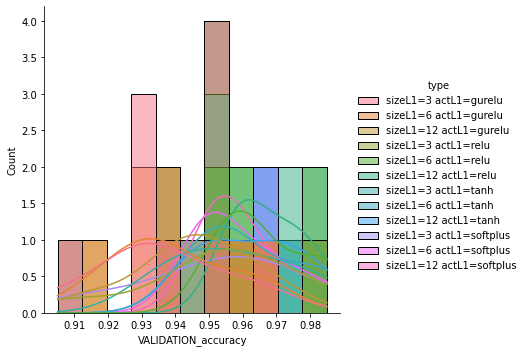

In [12]:
EVALUATION.plot_distributions('accuracy', mm.DataType.TRAIN)
EVALUATION.plot_distributions('accuracy', mm.DataType.VALIDATION)

### Paired statistical tests
We use a paired statistical tests between each model to check if the mean of the accurary of each is statistically different.
To do so we use 2 tests:
- Student paired t-test - parametric test that requires that the data is normal distributed.
- Wilcoxon signed rank test - non-parametric test that has no data requirement but has less power (larger type II error)

In [13]:
EVALUATION.set_p_threshold(0.01)
EVALUATION.paired_statistical_test('accuracy', mm.DataType.TRAIN)

+-----------------------------------------------------------------------+
|                  Normality of accuracy on TRAIN data                  |
+---------------------------+----------------------+--------------------+
|           Model           | Shapiro-Wilk p-value | Normal distributed |
+---------------------------+----------------------+--------------------+
|   sizeL1=3 actL1=gurelu   |        0.367         |        YES         |
|   sizeL1=6 actL1=gurelu   |        0.0444        |        YES         |
|  sizeL1=12 actL1=gurelu   |        0.9096        |        YES         |
|    sizeL1=3 actL1=relu    |        0.114         |        YES         |
|    sizeL1=6 actL1=relu    |       0.004986       |         NO         |
|   sizeL1=12 actL1=relu    |       0.04081        |        YES         |
|    sizeL1=3 actL1=tanh    |        0.6487        |        YES         |
|    sizeL1=6 actL1=tanh    |        0.9545        |        YES         |
|   sizeL1=12 actL1=tanh    |        0

C:\Users\suppo\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\suppo\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [14]:
EVALUATION.paired_statistical_test('accuracy', mm.DataType.VALIDATION)

+-----------------------------------------------------------------------+
|                Normality of accuracy on VALIDATION data               |
+---------------------------+----------------------+--------------------+
|           Model           | Shapiro-Wilk p-value | Normal distributed |
+---------------------------+----------------------+--------------------+
|   sizeL1=3 actL1=gurelu   |        0.4552        |        YES         |
|   sizeL1=6 actL1=gurelu   |        0.5279        |        YES         |
|  sizeL1=12 actL1=gurelu   |        0.7894        |        YES         |
|    sizeL1=3 actL1=relu    |        0.3216        |        YES         |
|    sizeL1=6 actL1=relu    |       0.06051        |        YES         |
|   sizeL1=12 actL1=relu    |        0.5331        |        YES         |
|    sizeL1=3 actL1=tanh    |        0.8689        |        YES         |
|    sizeL1=6 actL1=tanh    |        0.3373        |        YES         |
|   sizeL1=12 actL1=tanh    |        0

### Anova one-way tests
We use anova to check that the mean accuracy of all models (each model is a group) is the same or not.

Anova requires the group variances (model accuracies) to be equal so we also perform a Bartlett covariance test.

In [15]:
EVALUATION.oneway_anova_test('accuracy', mm.DataType.TRAIN)
EVALUATION.oneway_anova_test('accuracy', mm.DataType.VALIDATION)

+---------------------------------------------------------------------------+
|                             accuracy on TRAIN                             |
+--------------------+----------------+-----------------------+-------------+
|  Bartlett p-value  | Equal variance |  Oneway Anova p-value | Equal means |
+--------------------+----------------+-----------------------+-------------+
| 0.7395930623717406 |      YES       | 1.627160122006064e-14 |      NO     |
+--------------------+----------------+-----------------------+-------------+
+--------------------------------------------------------------------------+
|                          accuracy on VALIDATION                          |
+--------------------+----------------+----------------------+-------------+
|  Bartlett p-value  | Equal variance | Oneway Anova p-value | Equal means |
+--------------------+----------------+----------------------+-------------+
| 0.7753726630568274 |      YES       | 0.007636418002999354 |      N

### Tukey honestly significant difference test
Anova has the problem that it can only tell use if there is a difference between the mean of all the tests

We use Tukey HSD to do pairwise tests same as in the Student t-test.

In [16]:
EVALUATION.tukey_hsd_test('accuracy', mm.DataType.TRAIN)
EVALUATION.tukey_hsd_test('accuracy', mm.DataType.VALIDATION)

C:\Users\suppo\Desktop\RESEARCH\NN_research\matmih\evaluation.py:108: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  data_arr = np.hstack(models.values())


                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                    
          group1                    group2          meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------
  sizeL1=12 actL1=gurelu      sizeL1=12 actL1=relu    0.0382  0.001   0.013  0.0634   True
  sizeL1=12 actL1=gurelu  sizeL1=12 actL1=softplus    0.0343  0.001  0.0091  0.0595   True
  sizeL1=12 actL1=gurelu      sizeL1=12 actL1=tanh    0.0316 0.0036  0.0064  0.0568   True
  sizeL1=12 actL1=gurelu     sizeL1=3 actL1=gurelu   -0.0227 0.1191 -0.0479  0.0025  False
  sizeL1=12 actL1=gurelu       sizeL1=3 actL1=relu    0.0302 0.0068   0.005  0.0554   True
  sizeL1=12 actL1=gurelu   sizeL1=3 actL1=softplus    0.0171 0.4891 -0.0081  0.0423  False
  sizeL1=12 actL1=gurelu       sizeL1=3 actL1=tanh    0.0241 0.0742 -0.0011  0.0493  False
  sizeL1=12 actL1=gurelu     sizeL1=6 actL1=gurelu   -0.0116    0.9 -0.0368  0.0136  False